# Lab 3 - Query Expansion

In [1]:
file_path = 'parsed_text.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

filtered_text = ' '.join(lines)

pdf_texts= [filtered_text]

In [3]:
# This cell is the same as Lab 1 till we create the collection collapsed into a single block

import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)
   


In [4]:

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()

chroma_collection = chroma_client.create_collection("historia.txt", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)

chroma_collection.count()

4294

In [5]:
# This cell is the same as Lab 2 till we define the project_embeddings method

import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

/Users/damiangarayalde/Desktop/Work - Github Repos/AI/Advanced Retrieval for AI with Chroma/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 4294/4294 [19:44<00:00,  3.63it/s]


In [44]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [58]:
def augment_query_with_generated_answer(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "Quiero que actues como un profesor de historia." 
                        "Dada la pregunta provista, proveeme una respuesta esperable a encontrar en un libro de historia." 
                        "Limita la respuesta a una horacion de menos de 100 palabras."
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )

    hypothetical_answer = response.choices[0].message.content

    augmented_query = f"{query}: {hypothetical_answer}"

    return augmented_query

In [59]:
def propose_related_queries(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "Quiero que actues como un profesor de historia. Te haran preguntas sobre la informacion provista por un texto. "
            "Sugiera cinco (5) preguntas adicionales relacionadas con la pregunta original para ayudar en la busqueda de informacion en el texto para poder responder la pregunta provista. "
            "Sugiera unicamente preguntas cortas sin oraciones compuestas. Sugiera una variedad de preguntas que cubran los diferentes aspectos del asunto."
            "Asegurese de que las preguntas esten completas y tengan relacion con la pregunta provista."
            "Genere una pregunta por linea y no enumere las preguntas."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [61]:
def get_augmented_queries(question):

    related_queries = propose_related_queries(question)

    augmented_query = augment_query_with_generated_answer(question)

    queries =  [augmented_query]

    for q in related_queries:
        augmented_query = augment_query_with_generated_answer(q)
        queries = queries + [augmented_query]
        
    return queries

In [62]:
queriess = get_augmented_queries("Cuales fueron los personales mas influyentes llamados Carlos?")

for q in queriess:
    print(q)
    print('-'*100)

Cuales fueron los personales mas influyentes llamados Carlos?: Carlos I de España (también conocido como Carlos V del Sacro Imperio Romano Germánico) y Carlos II de España fueron dos de los personajes más influyentes de la historia europea.
----------------------------------------------------------------------------------------------------
¿Qué papel desempeñó Carlos I de España en la historia europea?   : Carlos I de España, también conocido como Carlos V de Alemania, fue una figura clave en la historia europea del siglo XVI al ser emperador del Sacro Imperio Romano Germánico y rey de España. Su reinado estuvo marcado por conflictos religiosos, guerras y expansión territorial, contribuyendo a la consolidación de los imperios español y alemán en Europa.
----------------------------------------------------------------------------------------------------
¿Cuál era el título completo de Carlos I de España?  : El título completo de Carlos I de España era Carlos I de España y V de Alemania.

In [63]:
results = chroma_collection.query(query_texts=queriess, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()

for documents in retrieved_documents:

    for document in documents:

        unique_documents.add(document)



for i, documents in enumerate(retrieved_documents):

    print(f"Query: {queriess[i]}")
    print('')
    print("Results:")

    for doc in documents:
        print(doc)
        print('')
        
    print('-'*100)

Query: Cuales fueron los personales mas influyentes llamados Carlos?: Carlos I de España (también conocido como Carlos V del Sacro Imperio Romano Germánico) y Carlos II de España fueron dos de los personajes más influyentes de la historia europea.

Results:
los gobiernos de frondizi y guido. si bien la figura del general juan carlos ongania, como jefe del ejercito,

, debia servirseles “ con buena vo luntad, con temor, respeto y sinceridad de corazon, como a jesucristo ”. aunque la tesis no se expuso en espana con prolijidad doctrinal,

165. durante el siglo xviii, y en especial en su segunda mitad, se advirtio en espana un afan renovador que produjo importantes cambios en la vida institucional de la monarquia, procurando borrar los rastros de una profunda decadencia. las nuevas ideas, provenientes de francia, llegaron eu compania de la casa de borbon, que sucedio a la de austria. conviene recordar que carlos il “ el hechizado ”, ultimo monarca habsburgo, murio en 1700 sin descendencia

In [66]:
original_query ="Cuales fueron los personales mas influyentes llamados Carlos?"

In [67]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(queriess)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


In [68]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 60/60 [00:16<00:00,  3.64it/s]


(-4.304471504688263,
 12.542200338840484,
 -3.4346214652061464,
 8.590541732311248)

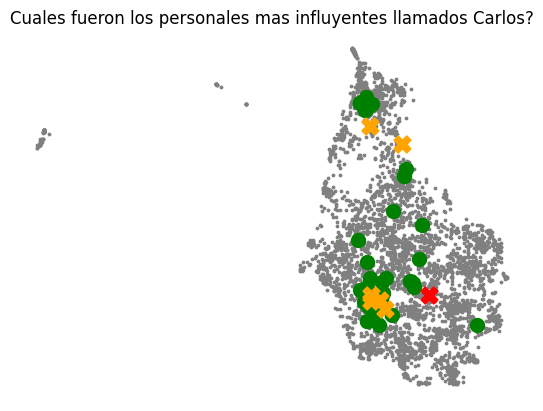

In [69]:
import matplotlib.pyplot as plt

plt.figure()

plt.scatter(projected_dataset_embeddings[  :, 0], projected_dataset_embeddings[  :, 1], s=3, color='gray')
plt.scatter(projected_result_embeddings[:, 0],    projected_result_embeddings[:, 1], s=100, facecolors='g', edgecolors='g')
plt.scatter(project_augmented_queries[:, 0],      project_augmented_queries[:, 1],       s=150, marker='X', color='orange')
plt.scatter(project_original_query[     :, 0],    project_original_query[     :, 1], s=150, marker='X', color='r')



plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

In [70]:
# The information provided in the 'content' is the key for how the system will behave. 
# Feel free to modify it and test different scenarios

def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "Eres un estudiante avanzado de derecho especializado en historia. Tus usuarios son profesores que hacen preguntas sobre información contenida en un texto de historia. Se te mostrará la pregunta del usuario y fragmentos del texto con información relevante a la pregunta. Responde la pregunta del usuario utilizando solo esta información."
        },
        {"role": "user", "content": f"Pregunta: {query}. \n Información: {information}"}
    ]
    

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [71]:
def get_tedtalk_answer(question, detail_retrieved_docs = True ):

    queries = get_augmented_queries(question)

    results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])


    # Under the hood the .query() method will embedd the query using the same embedding funtion used when adding the documents. 
    # Here is where chroma_db searchs for the documents that look similar to the query and then return some documents (5 here)

    retrieved_documents = results['documents'][0]




    # If required we can list the retrieved fragments:
    if detail_retrieved_docs==True:

        print('Los fragmentos que poseen una mayor relacion con la pregunta son: \n')

        for document in retrieved_documents:
            print(document)
        
        print('\n La respuesta construida en base a dichos fragmentos es: ')


    output = rag(query=question, retrieved_documents=retrieved_documents)
        
    return output

In [72]:
get_tedtalk_answer( "cuales son las bulas papales" )

Los fragmentos que poseen una mayor relacion con la pregunta son: 

el catolicismo gano considerable espacio publico. las celebraciones religiosas reunian en plazas y calles a crecidas concurrencias. muestra significativa de ello fue la celebracion en buenos aires del xxxii congreso eucaristico internacional en 1934. se trato de una manifestacion de fe colectiva, de tal magnitud como nunca se habia visto en el pais. ademas de su propia e intima significacion estrictamente espiritual - como el acercamiento de miles de varones a la practica religiosa — tuvo tambien efectos institucionales en cuanto a la presencia de la iglesia en la vida publica. de particular interes en el orden de las relaciones con la santa sede fue el hecho de que el delegado pontificio a dicho congreso, el cardenal eucento pacelll, resulto en 1939 elevado al trono pontificio bajo el nombre de pio
. el papado, sin posibilidad material ni moral para llevar a cabo esa empresa, resolvio delegar en los monarcas castellan

'Las bulas papales eran documentos emitidos por el papado que concedían ciertos privilegios o facultades espirituales a los monarcas castellanos en el siglo XVI. Por ejemplo, se menciona que una de las bulas concedía a los monarcas los diezmos que correspondía percibir en las indias, a cambio de que la corona proveyera la sustentación del culto divino y de sus sacerdotes. Además, se señala que las bulas de la santa cruzada eran un derecho eclesiástico asignado en España para la lucha contra los musulmanes, y que ingresaba en las arcas reales por concesión especial del papa, variando el monto de acuerdo con la indulgencia contenida en la bula y la capacidad económica del beneficiado.'

In [73]:
get_tedtalk_answer( "Cuales fueron los personajes llamados Carlos mas significativos del siglo 14 y su principal importancia?" )

Los fragmentos que poseen una mayor relacion con la pregunta son: 

fue dominante en el concepto de las generaciones ilustradas. por eso se condenaron las doctrinas de vrroria, suarez, mariana y todos aquellos que trataron de senalar limitaciones a la autoridad regia. como ejemplo de cuanto decimos, veanse estas preguntas y respuestas contestadas en un catecismo de caracter politico, redactado por el obispo de cordoba de tucuman, fray jose antonio de san alberto, impreso en 1783 para la ensenanza de los ninos : - “ ¿ quien, pues, es el origen de los reyes? - dios mismo, de quien se deriva toda potestad. - ¿ por que los reyes se llamaron dioses? - porque en su reino son unas imagenes visibles de dios. - ¿ quien es superior al rey? - solo dios en lo civil y temporal de su reino. - el rey, ¿ esta sujeto al pueblo? - no, que esto seria estar sujeta la
167. la exaltacion del poder real fue tema corriente de toda la literatura politica de este siglo. contra una tradicion espanola que habia f

'Respuesta: Dos personajes llamados Carlos que fueron significativos en el siglo XIV fueron Carlos III "el hechizado" (1665-1700) y Carlos IV (1788-1808). Carlos III fue un rey que abandonó los problemas de administración en favor de validos o primeros ministros. Por su parte, Carlos IV fue un rey cuyo reinado marcó una crisis de poder que selló la suerte de la monarquía debido a su favorito Manuel Godoy y la invasión francesa de España bajo Napoleón.'